## Imports

In [11]:
import multiprocessing
import os
import pickle
import time

import energyflow as ef
from energyflow.datasets import mod
import matplotlib.pyplot as plt
import numpy as np

# requires fastjet to calculate zg
import fastjet as fj
import modplot
import utils

save_plots = False

## Load MOD Datasets

In [12]:
# make selections (consider amount = 0.01 for quick testing)
ptmin, ptmax = 375, 425
absetamax = '1.9'
pt_cut = 1.0
amount = 1.0
specs = [(ptmin, '<=corr_jet_pts<', ptmax), 'abs_jet_eta < {}'.format(absetamax), 'quality >= 2']

# use this if you've previously selected custom datasets
path = '~/.energyflow/'
preselected = True

In [13]:
if not preselected:
    cms = mod.load(*specs, dataset='cms', amount=amount)
    sim = mod.load(*specs, dataset='sim', amount=amount, store_gens=False)
    gen = mod.load(*specs, dataset='gen', amount=amount)

else:
    # make sure the path points to where you saved the custom datasets
    fullpath = os.path.join(os.path.expanduser(path), 'datasets/CMS2011AJets')
    cms = mod.MODDataset('cms/CMS_Jet300_pT375-infGeV', *specs, path=fullpath)
    sim = mod.MODDataset('sim/SIM_Jet300_pT{}-{}GeV'.format(ptmin, ptmax), *specs, 
                         path=fullpath, store_gens=False)
    gen = mod.MODDataset('sim/GEN_pT{}-{}GeV'.format(ptmin, ptmax), *specs, path=fullpath)    

## Observables

In [ ]:
def to_pjs(event):
    pjs = []
    for particle in event:
        pj = fj.PseudoJet()
        pj.reset_PtYPhiM(*particle)
        pjs.append(pj)
    return pjs

def to_CA_jet(jet_consts):
    CA_def = fj.JetDefinition(fj.cambridge_aachen_algorithm, fj.JetDefinition.max_allowable_R)
    CA_jets = CA_def(jet_consts)
    assert len(CA_jets) == 1
    return CA_jets[0]

zcut, R = 0.1, 0.5
def softdrop_beta0(CA_jet):
    parent1, parent2 = fj.PseudoJet(), fj.PseudoJet()
    if not CA_jet.has_parents(parent1, parent2):
        return CA_jet
    
    pt1, pt2 = parent1.pt(), parent2.pt()
    if min(pt1, pt2)/(pt1 + pt2) >= zcut:
        return CA_jet
    else:
        return softdrop_beta0(parent1 if pt1 > pt2 else parent2)
    
def zg(sd_jet):
    parent1, parent2 = fj.PseudoJet(), fj.PseudoJet()
    if not sd_jet.has_parents(parent1, parent2):
        return 0.
    
    pt1, pt2 = parent1.pt(), parent2.pt()
    return min(pt1, pt2)/(pt1 + pt2)

e2 = ef.EFP([(0,1)], measure='hadr', beta=1, check_input=False)
e3 = ef.EFP([(0,1), (1,2), (0,2)], measure='hadr', beta=1, check_input=False)

bins_around_zero = np.linspace(-0.5, 0.5, 34)

def obs_from_particles(i, reg=10**-30):
    
    particles_i = particles[i]
    
    # get appropriate filters
    mask = utils.filter_particles(particles_i, chs=True, pt_cut=pt_cut)
    
    # mask particles
    masked_ptyphims = particles_i[mask,:5]
    track_mask = ef.ischrgd(masked_ptyphims[:,4])
    track_masked_ptyphims = masked_ptyphims[track_mask,:4]
    masked_ptyphims = masked_ptyphims[:,:4]
    
    # compute masses
    pt_tot, y_tot, phi_tot, mass = ef.sum_ptyphims(masked_ptyphims)
    track_pt_tot, track_y_tot, track_phi_tot, track_mass = ef.sum_ptyphims(track_masked_ptyphims)
    
    # mults are easy
    mult = len(masked_ptyphims)
    track_mult = len(track_masked_ptyphims)
    
    # ptd
    ptd = np.sqrt(np.sum(masked_ptyphims[:,0]**2))/(np.sum(masked_ptyphims[:,0]) + reg)
    track_ptd = np.sqrt(np.sum(track_masked_ptyphims[:,0]**2))/(np.sum(track_masked_ptyphims[:,0]) + reg)
    
    # npv
    npv = len(np.unique(particles_i[:,5]))
    
    # N95
    pixels = np.histogram2d(masked_ptyphims[:,1], masked_ptyphims[:,2], weights=masked_ptyphims[:,0], 
                            bins=(y_tot + bins_around_zero, phi_tot + bins_around_zero))[0].flatten()
    n95 = np.argmax(np.cumsum(np.sort(pixels/(pixels.sum() + reg))[::-1]) >= 0.95) + 1
    
    track_pixels = np.histogram2d(track_masked_ptyphims[:,1], track_masked_ptyphims[:,2], 
                            weights=track_masked_ptyphims[:,0], 
                            bins=(track_y_tot + bins_around_zero, track_phi_tot + bins_around_zero))[0].flatten()
    track_n95 = np.argmax(np.cumsum(np.sort(track_pixels/(track_pixels.sum() + reg))[::-1]) >= 0.95) + 1
    
    # z_g
    pjs = np.asarray(to_pjs(masked_ptyphims))
    zg_val = zg(softdrop_beta0(to_CA_jet(pjs))) if len(pjs) else 0.
    track_zg_val = zg(softdrop_beta0(to_CA_jet(pjs[track_mask]))) if np.any(track_mask) else 0.
    
    # D2
    d2 = np.log(e3.compute(masked_ptyphims)/(e2.compute(masked_ptyphims)**3 + reg) + reg)
    track_d2 = np.log(e3.compute(track_masked_ptyphims)/(e2.compute(track_masked_ptyphims)**3 + reg) + reg)
    
    return (mass, track_mass, mult, track_mult, ptd, track_ptd, npv, 
            n95, track_n95, zg_val, track_zg_val, d2, track_d2)

In [ ]:
ob_names = ['Mass', 'TrackMass', 'Mult', 'TrackMult', 'pTD', 'TrackpTD', 'nPVJet', 
            'N95', 'TrackN95', 'zg', 'Trackzg', 'D2', 'TrackD2']
obs = {name: {} for name in ob_names}
obs.update({'nPV': {'cms_values': cms.npvs, 'sim_values': sim.npvs}})

# iterate over datasets
for dset in [cms, sim, gen]:
    start = time.time()
    
    particles = dset.particles
    inds = np.arange(len(particles))
    
    # calculate observables
    with multiprocessing.Pool(processes=None) as pool:
        obs_vals = np.asarray(list(pool.map(obs_from_particles, inds))).T
    
    # store values
    for i,ob_name in enumerate(ob_names):
        obs[ob_name][dset.dataset + '_values'] = obs_vals[i]
        
    print(dset.dataset, 'completed in {:.3f}s'.format(time.time() - start))
    
name = 'SubstructureObservables_{}-{}GeV.pickle'.format(ptmin, ptmax)
with open(os.path.join(utils.DATAPATH, 'plotdata', name), 'wb') as f:
    pickle.dump(obs, f)

In [14]:
name = 'SubstructureObservables_{}-{}GeV.pickle'.format(ptmin, ptmax)
obs = np.load(os.path.join(utils.DATAPATH, 'plotdata', name), allow_pickle=True)

In [15]:
sim_factors = utils.sim_factors(sim.corr_jet_pts, sim.npvs)
gen_factors = utils.gen_factors(gen.jet_pts)

In [23]:
# the jet mass
obs['Mass'].update({
    'nbins': 50,
    'xlabel': r'Mass $m$ [GeV]', 
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 120), 'ylim': (0, 0.015), 'ylim_ratio': (0.5, 1.75),
    'xtick_step': 20, 'ytick_step': 0.005, 'ytick_ratio_step': 0.25,
    'tx': 46.5, 'ty': 252,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# the jet track mass
obs['TrackMass'].update({
    'nbins': 50,
    'xlabel': r'Track Mass $m_{\text{track}}$ [GeV]', 
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 80), 'ylim': (0, 0.02), 'ylim_ratio': (0.5, 1.75),
    'xtick_step': 20, 'ytick_step': 0.005, 'ytick_ratio_step': 0.25,
    'tx': 46.5, 'ty': 252.5,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# the constituent multiplicity
obs['Mult'].update({
    'nbins': 80,
    'xlabel': r'Constituent Multiplicity $M$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 80), 'ylim': (0, 0.02), 'ylim_ratio': (0.25, 1.75),
    'xtick_step': 20, 'ytick_step': 0.005, 'ytick_ratio_step': 0.25,
    'tx': 46.5, 'ty': 251,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# the track constituent multiplicity
obs['TrackMult'].update({
    'nbins': 60,
    'xlabel': r'Track Multiplicity $M_{\text{track}}$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 60), 'ylim': (0, 0.03), 'ylim_ratio': (0.25, 1.75),
    'xtick_step': 15, 'ytick_step': 0.005, 'ytick_ratio_step': 0.25,
    'tx': 46.5, 'ty': 251,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# the transverse momentum dispersion
obs['pTD'].update({
    'nbins': 50,
    'xlabel': r'Transverse Momentum Dispersion $p_T^D$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 1), 'ylim': (0, 2), 'ylim_ratio': (0.5, 1.5),
    'xtick_step': 0.2, 'ytick_step': 0.25, 'ytick_ratio_step': 0.25,
    'tx': 44.1, 'ty': 253.25,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# the track transverse momentum dispersion
obs['TrackpTD'].update({
    'nbins': 50,
    'xlabel': r'Track Transverse Momentum Dispersion $p_{T,\text{track}}^D$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 1), 'ylim': (0, 2), 'ylim_ratio': (0.5, 1.5),
    'xtick_step': 0.2, 'ytick_step': 0.25, 'ytick_ratio_step': 0.25,
    'tx': 44.1, 'ty': 255,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# the number of pileup vertices in the jet
obs['nPV'].update({
    'nbins': 26,
    'xlabel': r'Number of Primary Vertices in Event', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 25), 'ylim': (0, 0.08), 'ylim_ratio': (0.0, 2),
    'xtick_step': 5, 'ytick_step': 0.02, 'ytick_ratio_step': 0.5,
    'tx': 41.5, 'ty': 251,
})

# the number of pileup vertices in the jet
obs['nPVJet'].update({
    'nbins': 16,
    'xlabel': r'Number of Primary Vertices in Jet', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 15), 'ylim': (0, 0.12), 'ylim_ratio': (0.0, 2),
    'xtick_step': 5, 'ytick_step': 0.02, 'ytick_ratio_step': 0.5,
    'tx': 41.5, 'ty': 251,
})

# N95
obs['N95'].update({
    'nbins': 50,
    'xlabel': r'Image Activity $N_{95}$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 50), 'ylim': (0, 0.035), 'ylim_ratio': (0.25, 1.75),
    'xtick_step': 10, 'ytick_step': 0.01, 'ytick_ratio_step': 0.25,
    'tx': 43.7, 'ty': 251,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# Track N95
obs['TrackN95'].update({
    'nbins': 40,
    'xlabel': r'Track Image Activity $N_{95,\text{track}}$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 40), 'ylim': (0, 0.035), 'ylim_ratio': (0.25, 1.75),
    'xtick_step': 10, 'ytick_step': 0.01, 'ytick_ratio_step': 0.25,
    'tx': 44.2, 'ty': 252,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# z_g
obs['zg'].update({
    'nbins': 50,
    'xlabel': r'Groomed Momentum Fraction $z_g$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 0.5), 'ylim': (0, 3.5), 'ylim_ratio': (0.25, 1.75),
    'xtick_step': 0.1, 'ytick_step': 0.5, 'ytick_ratio_step': 0.25,
    'tx': 43.9, 'ty': 252,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# Track z_g
obs['Trackzg'].update({
    'nbins': 50,
    'xlabel': r'Track Groomed Momentum Fraction $z_{g,\text{track}}$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 0.5), 'ylim': (0, 3.5), 'ylim_ratio': (0.25, 1.75),
    'xtick_step': 0.1, 'ytick_step': 0.5, 'ytick_ratio_step': 0.25,
    'tx': 43.9, 'ty': 252.25,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# D2
obs['D2'].update({
    'nbins': 50,
    'xlabel': r'$\ln D_2$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (-1, 4), 'ylim': (0, 0.4), 'ylim_ratio': (0.25, 1.75),
    'xtick_step': 1, 'ytick_step': 0.1, 'ytick_ratio_step': 0.25,
    'tx': 44.2, 'ty': 251,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

# Track D2
obs['TrackD2'].update({
    'nbins': 50,
    'xlabel': r'Track $\ln D_{2,\text{track}}$', 
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (-1, 4), 'ylim': (0, 0.4), 'ylim_ratio': (0.25, 1.75),
    'xtick_step': 1, 'ytick_step': 0.1, 'ytick_ratio_step': 0.25,
    'tx': 44.2, 'ty': 252,
    'line_2': r'CHS, $p_T^{\rm PFC}>1$ GeV',
})

## Histograms

In [17]:
density = False
reg = 10**-30

hists, errs = {}, {}
for key,ob in obs.items():
    
    start = time.time()
    
    # get bins
    ob['bins'] = bins = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins']+1)
    ob['step'] = step = bins[1] - bins[0]
    
    # CMS
    cms_hist, cms_errs, _ = modplot.calc_hist(ob['cms_values'], bins=bins, weights=cms.weights, density=density)
    if not density:
        cms_hist /= step
        cms_errs /= step
    hists[key+'_cms'], errs[key+'_cms'] = cms_hist, cms_errs

    # SIM
    sim_hist, sim_errs, _ = modplot.calc_hist(ob['sim_values'], bins=bins,
                                              weights=sim.weights*sim_factors, density=density)
    if not density:
        sim_hist /= step
        sim_errs /= step
    hists[key+'_sim'], errs[key+'_sim'] = sim_hist, sim_errs
    
    # GEN
    if 'nPV' not in key:
        gen_hist, gen_errs, _ = modplot.calc_hist(ob['gen_values'], bins=bins,
                                                  weights=gen.weights*gen_factors, density=density)
        if not density:
            gen_hist /= step
            gen_errs /= step
        hists[key+'_gen'], errs[key+'_gen'] = gen_hist, gen_errs
        
    # special case
    if key == 'nPV' or key == 'nPVJet':
        
        # note, deliberately using gen weights here to get unreweighted by npv weights
        hist, err, _ = modplot.calc_hist(ob['sim_values'], bins=bins, density=density,
                                          weights=sim.weights*utils.gen_factors(sim.corr_jet_pts))
        if not density:
            hist /= step
            err /= step
        hists[key+'_extra'], errs[key+'_extra'] = hist, err
    
    print('Calculated hists for {} in {:.3f}s'.format(key, time.time() - start))

Calculated hists for Mass in 3.919s
Calculated hists for TrackMass in 2.552s
Calculated hists for Mult in 2.574s
Calculated hists for TrackMult in 2.253s
Calculated hists for pTD in 2.394s
Calculated hists for TrackpTD in 2.479s
Calculated hists for nPVJet in 1.387s
Calculated hists for N95 in 2.205s
Calculated hists for TrackN95 in 2.019s
Calculated hists for zg in 2.841s
Calculated hists for Trackzg in 2.894s
Calculated hists for D2 in 2.201s
Calculated hists for TrackD2 in 1.917s
Calculated hists for nPV in 1.550s


## Plots

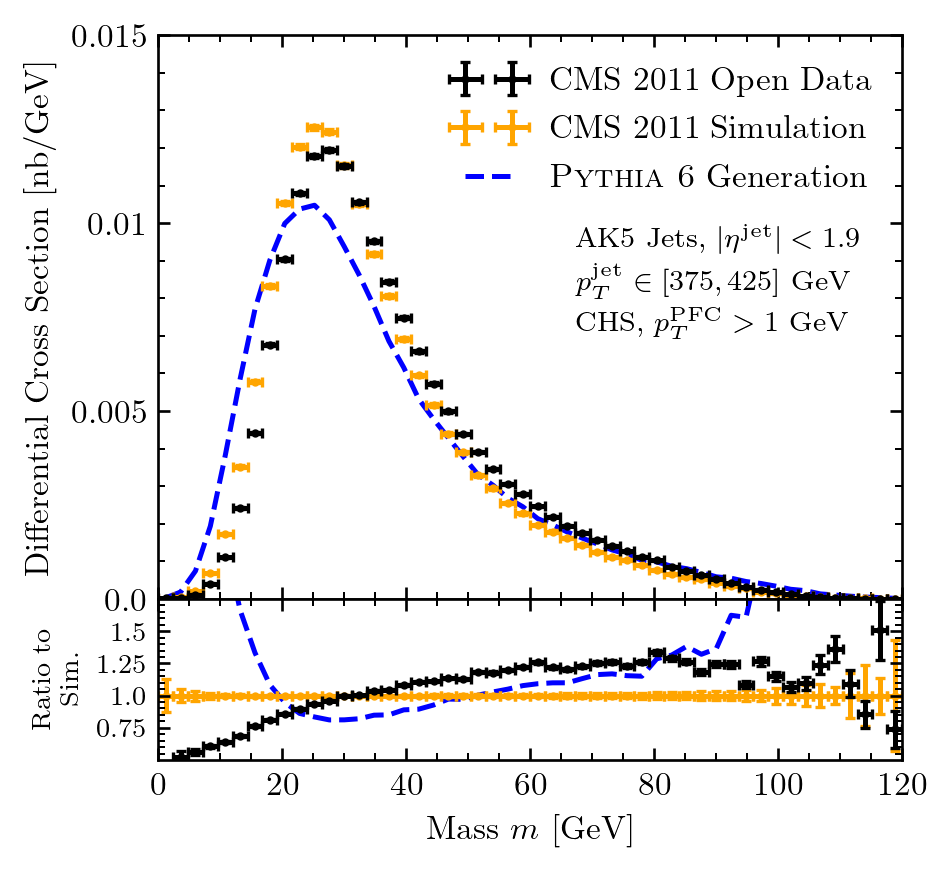

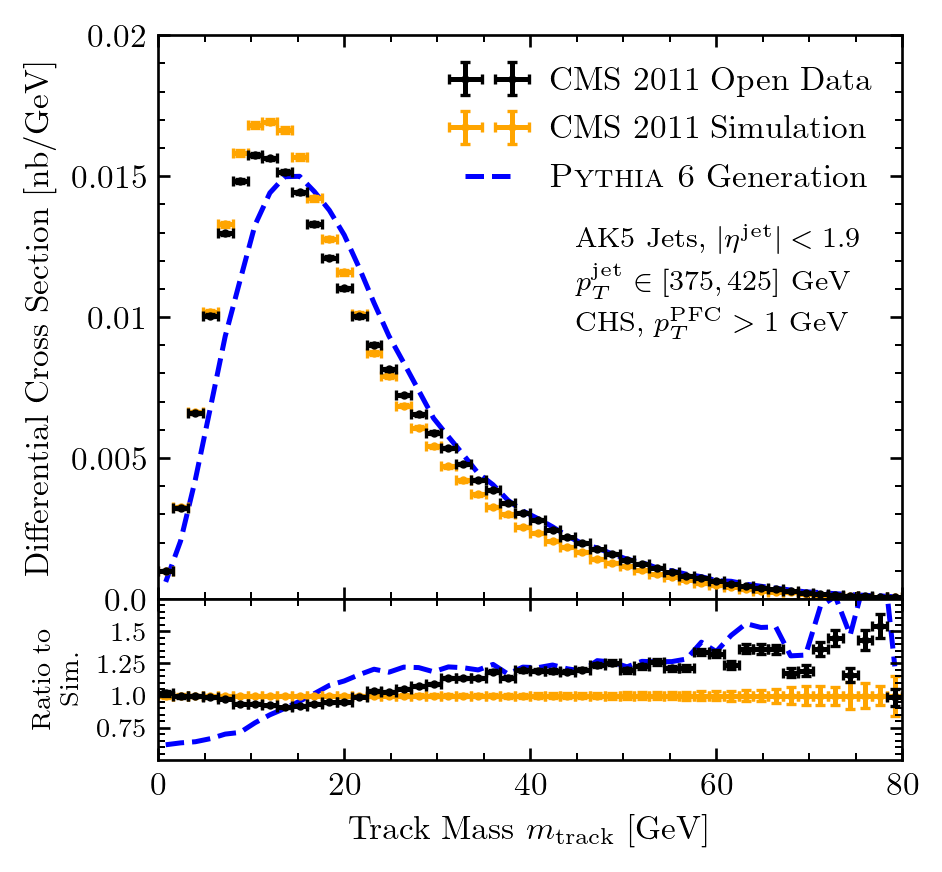

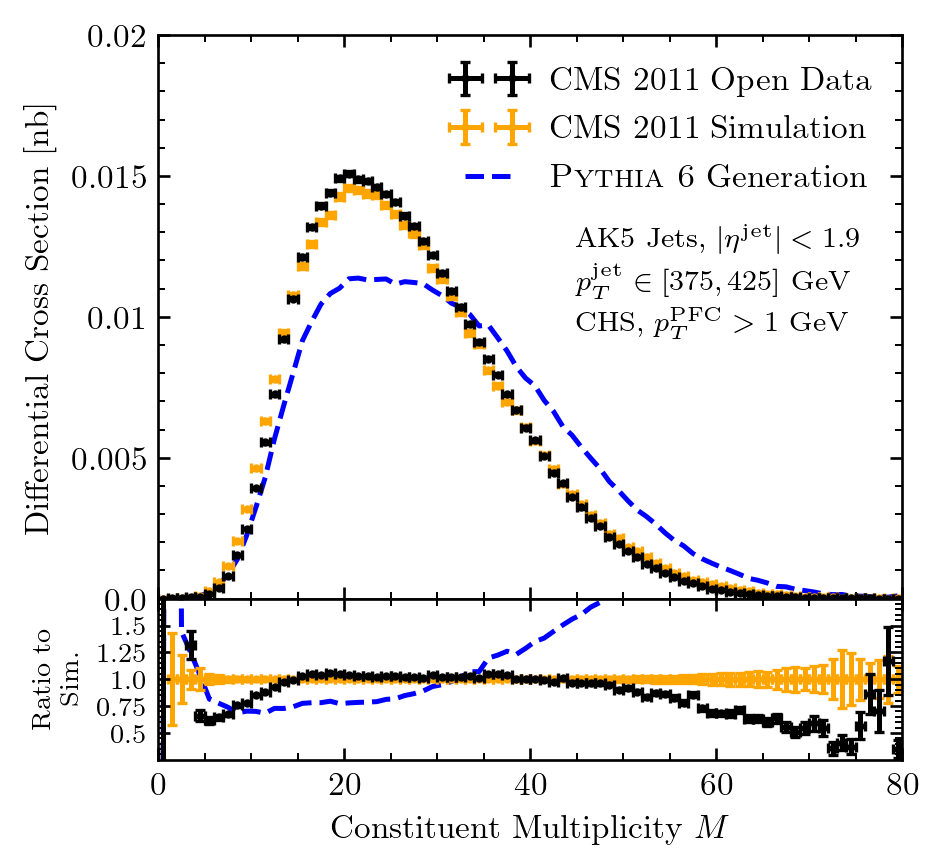

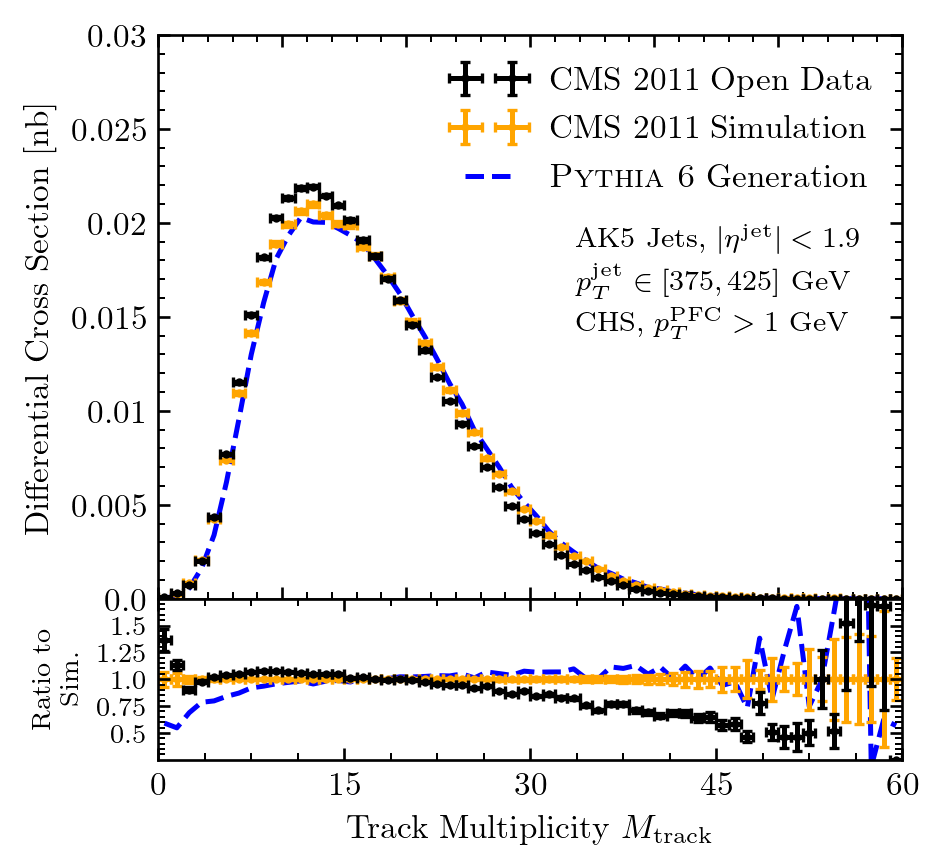

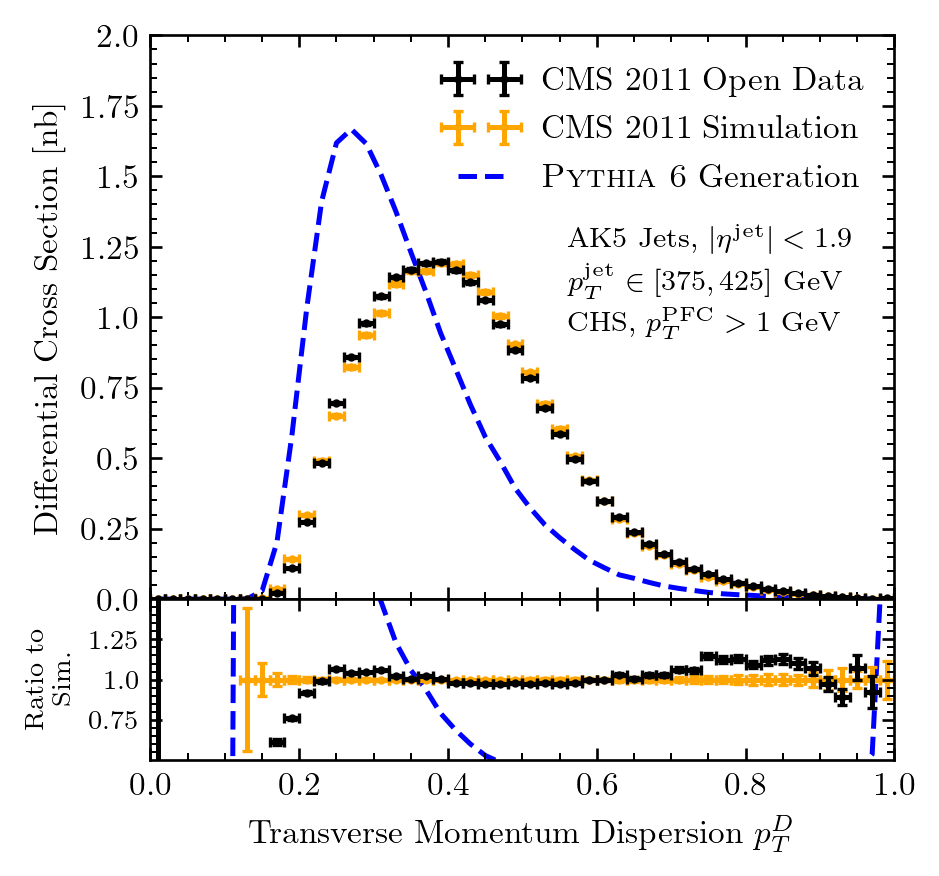

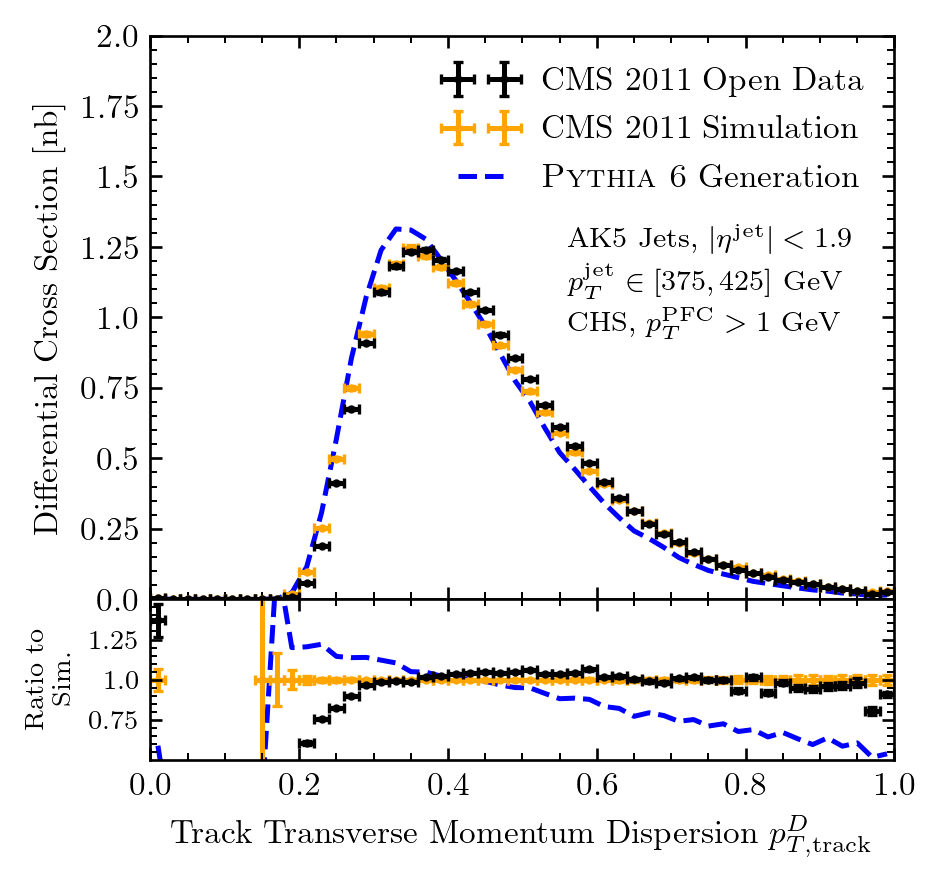

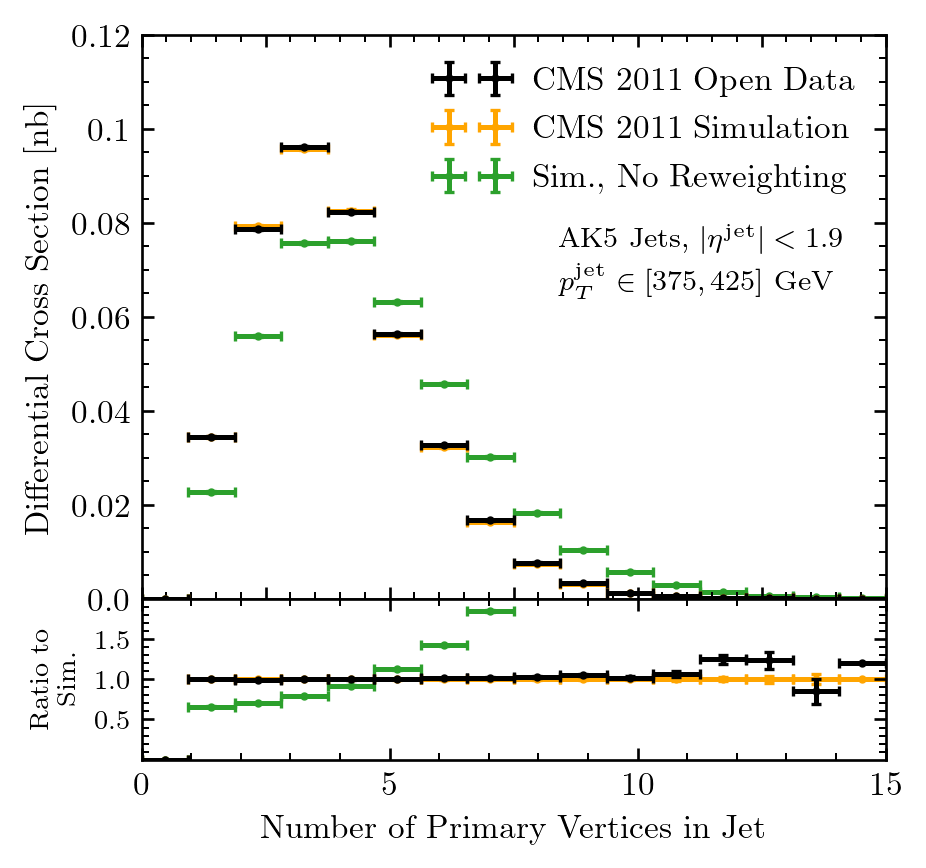

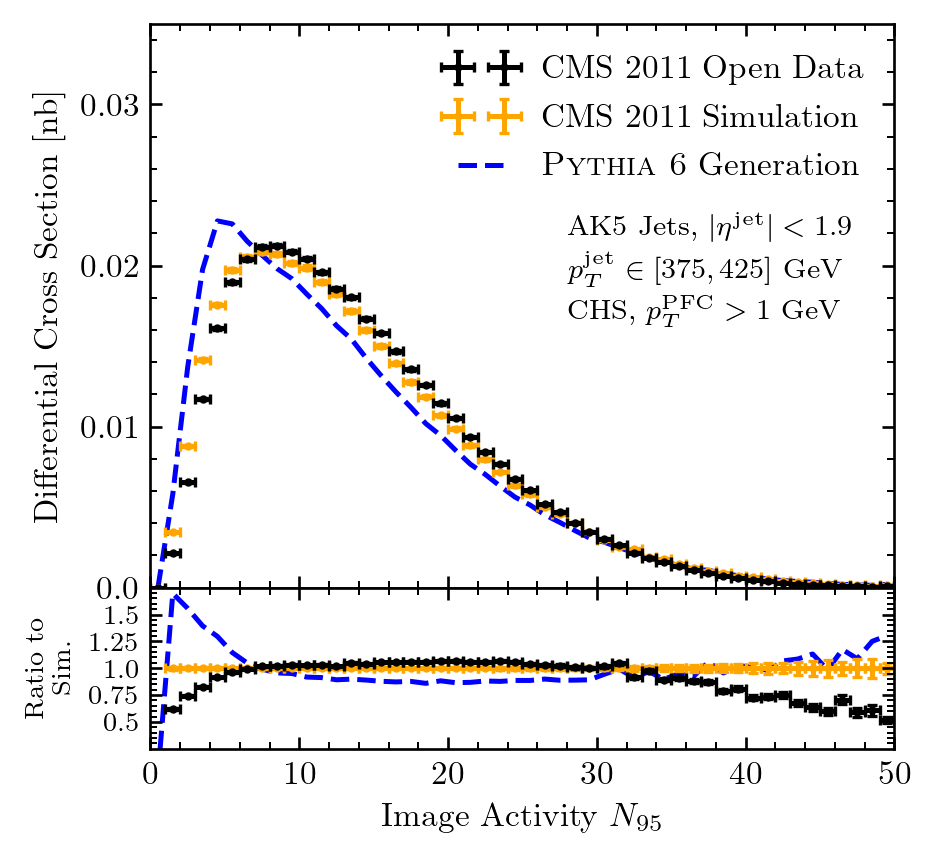

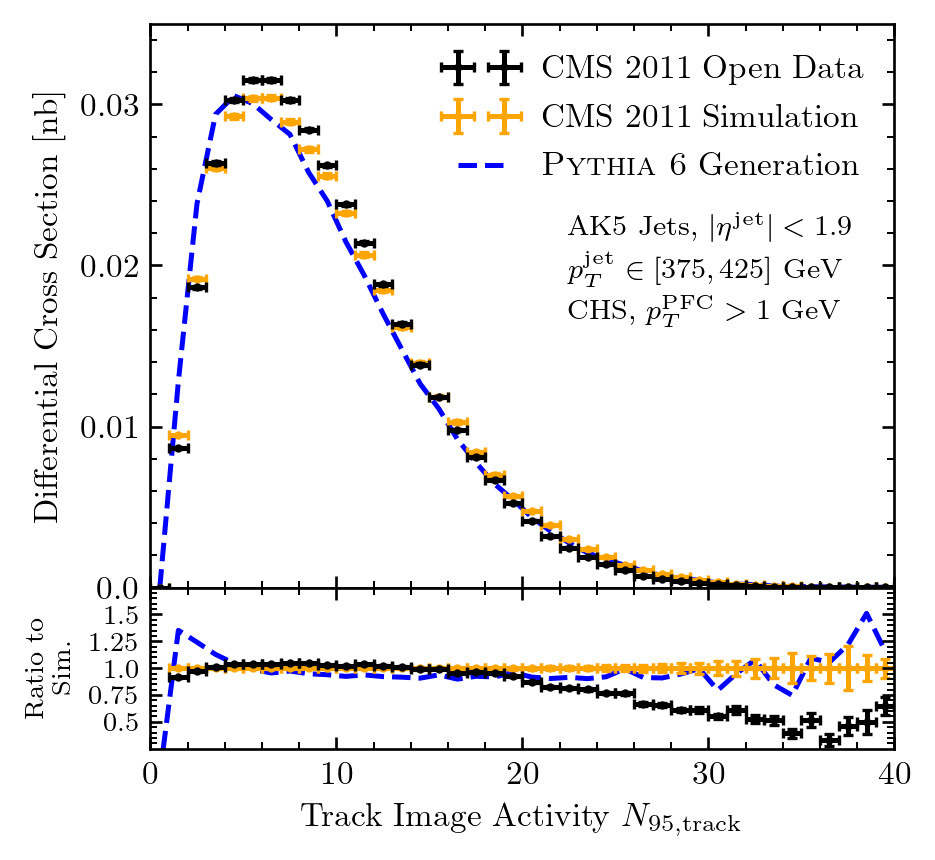

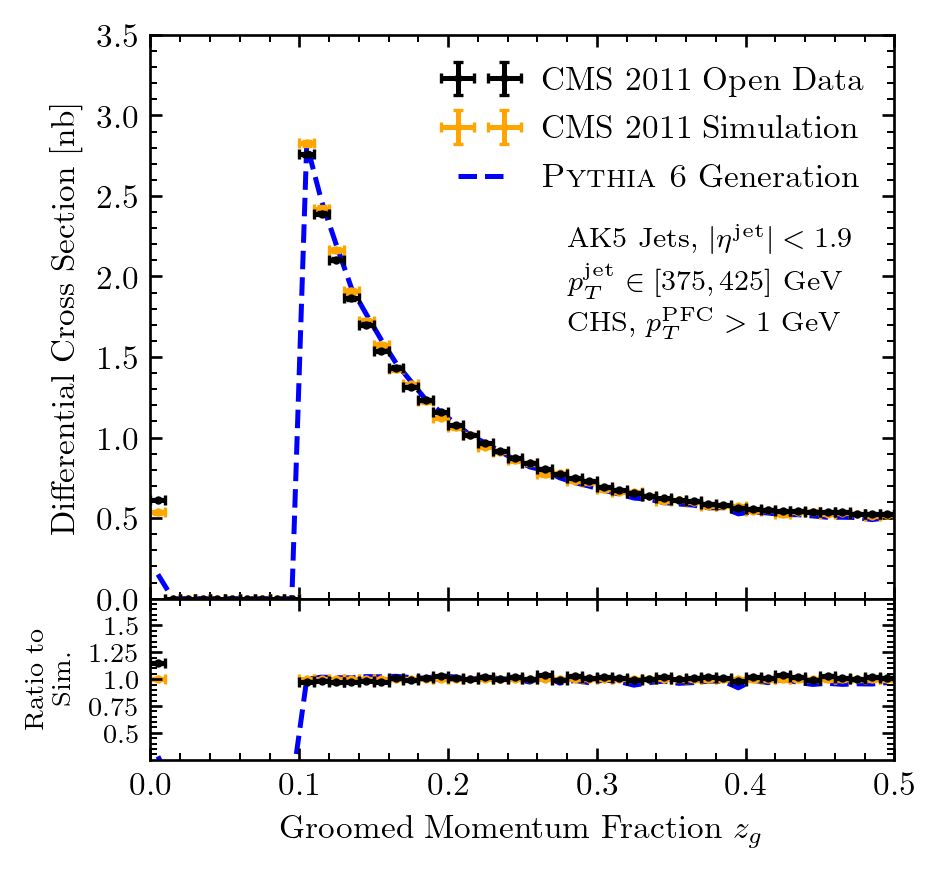

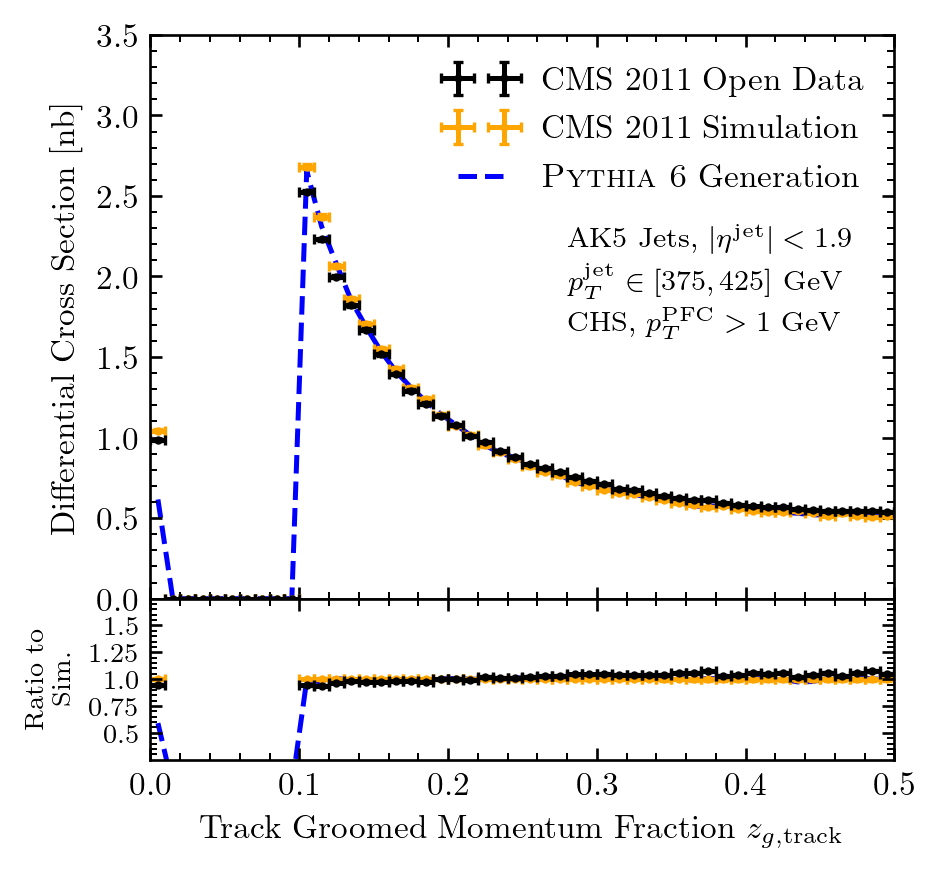

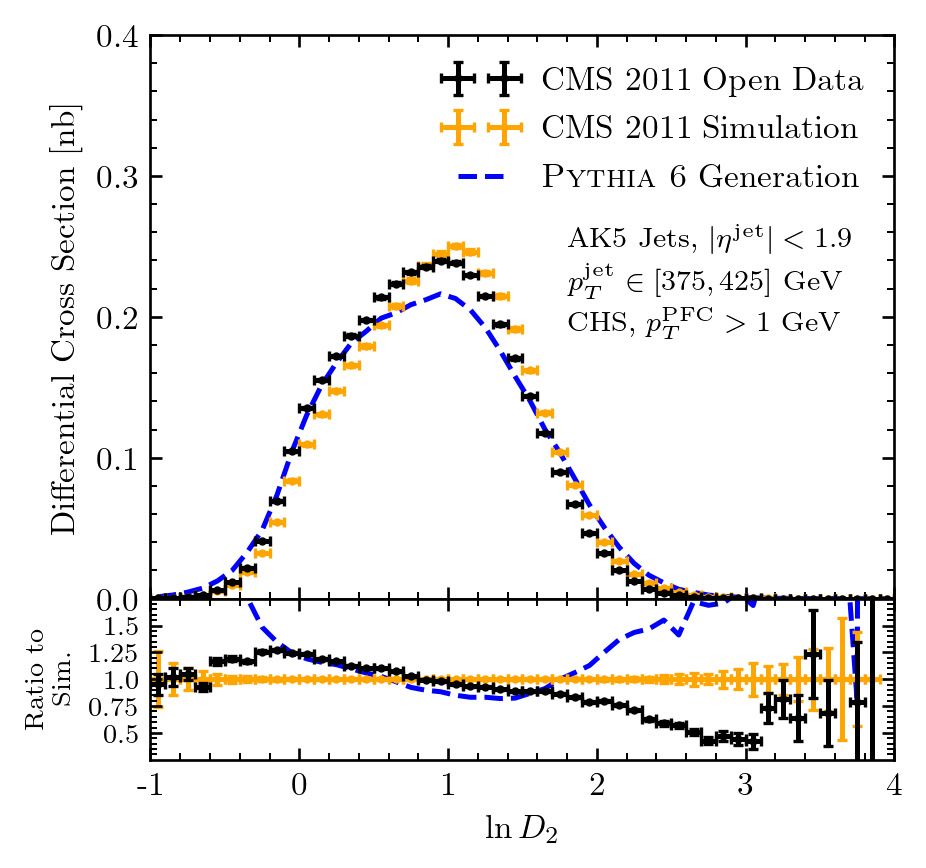

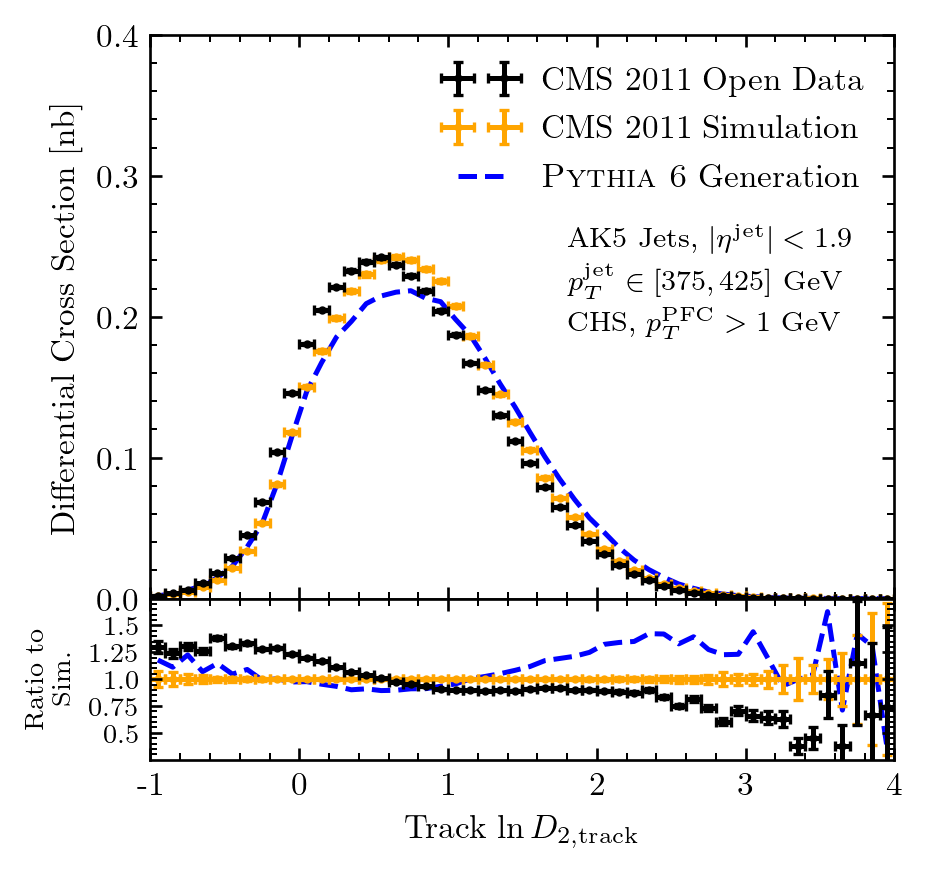

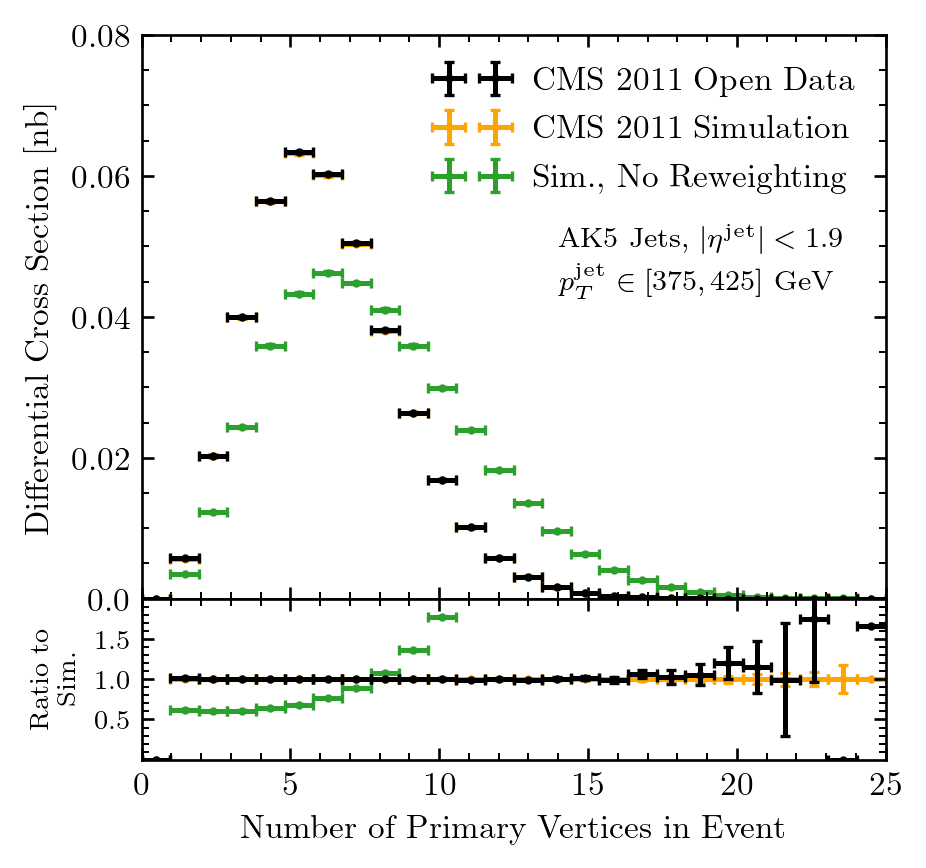

In [24]:
line_0 = r'AK5 Jets, $|\eta^{\rm jet}|<1.9$'
line_1 = r'$p_T^{\rm jet}\in' + '[{},{}]$ GeV'.format(ptmin, ptmax)
for key,ob in obs.items():
    
    #if not any([k in key for k in ['N95', 'zg', 'D2']]):
    #    continue

    # get axes in MOD plot format
    fig, axes = modplot.axes(ratio_plot=True, **ob)

    # get bins
    bins, step = ob['bins'], ob['step']
    midbins = (bins[1:] + bins[:-1])/2

    # get hists
    cms_hist, cms_errs = hists[key+'_cms'], errs[key+'_cms']
    sim_hist, sim_errs = hists[key+'_sim'], errs[key+'_sim']
    
    # CMS
    axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
    axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2,
                     yerr=cms_errs/(sim_hist+reg), **modplot.cms_style(), zorder=2)

    # SIM
    axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
    axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2,
                     yerr=sim_errs/(sim_hist+reg), **modplot.sim_style(), zorder=1)

    # GEN
    if 'nPV' not in key:
        gen_hist, gen_errs = hists[key+'_gen'], errs[key+'_gen']
        axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
        axes[1].plot(midbins, gen_hist/(sim_hist + reg), **modplot.gen_style(), zorder=0)
        
    # extra
    if key == 'nPV' or key == 'nPVJet':
        hist, err = hists[key+'_extra'], errs[key+'_extra']
        sim_style = modplot.sim_style()
        sim_style['color'] = 'tab:green'
        sim_style['label'] = 'Sim., No Reweighting'
        axes[0].errorbar(midbins, hist, xerr=step/2, yerr=err, **sim_style, zorder=1)
        axes[1].errorbar(midbins, hist/(sim_hist+reg), xerr=step/2,
                         yerr=err/(sim_hist+reg), **sim_style, zorder=1)
        
    # additional plot modifications
    modplot.stamp(0.56, 0.64, ax=axes[0], line_0=line_0, line_1=line_1, line_2=ob.get('line_2'), 
                  line_3=ob.get('line_3'))
    modplot.legend(ax=axes[0], order=[1,2,0] if 'nPV' not in key else None)

    # save plot
    if save_plots:
        modplot.save(fig, key, tx=ob['tx'], ty=ob['ty'], out_plots_dir='../plots/JetSubstructure')
    fig.show()